# Классификатор для изображений с монотонным фоном
### Назначение: Обучение CNN классификатора для изображений с монотонным фоном
### Автор : Степанов Семён Степанович
### Лицензия : GNU Lesser General Public License v2.1
### Вход : все изображения с однотонным фоном в разрешении 400x400
### Выход : обученная модель в .pt

In [6]:
import torch
import torchvision
import tqdm
import sys
import os

from IPython.display import clear_output
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, auc, roc_curve
from tqdm.notebook import tqdm_notebook

import numpy as np
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models

clear_output()

In [2]:
sns.set_theme()
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

### Разделение на обучающую и тестовую выборку в отношении 1 к 4

In [3]:
dataset = torchvision.datasets.ImageFolder(root="C:/Users/Wxei/fitoClean/Data400/")

split_ratio = 0.8

train_size = int(split_ratio * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

### Добавление аугментаций и фильтра imagenet

In [4]:
train_set.dataset.transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.CIFAR10),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomPosterize(bits=2),
    torchvision.transforms.RandomPerspective(distortion_scale=0.05, p=1.0),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_set.dataset.transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=6)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=6)

cuda = torch.device('cuda')

### Инициализация модели (измененный alexnet)

In [7]:
model = models.alexnet(pretrained=True)

In [8]:
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features=9216, out_features=128, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=3, bias=True)
)

In [9]:
model.to(cuda)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=128, bias=True)
  

### Подсчет кол-ва объектов каждого класса и балансировка

In [10]:
from collections import Counter

count = Counter(dataset.targets)
count

Counter({0: 442, 1: 804, 2: 745})

In [11]:
healthy_count = count[0]
rot_count = count[1]
rust_count = count[2]
sum_count = healthy_count + rust_count + rust_count

class_weights = torch.tensor([sum_count / healthy_count, sum_count/rot_count, sum_count / rust_count], dtype=torch.float)
class_weights

tensor([4.3710, 2.4030, 2.5933])

In [16]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(cuda))
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

n_epochs = 10

### Построение пайплайна для обучения и тестирования модели

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device="cuda:0"):
    model.train()
    train_losses = []
    for imgs, true_labels in train_loader:
        out = model(imgs.to(device)).squeeze()
        loss = criterion(out, true_labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    sns.lineplot(x=range(len(train_losses)), y=train_losses)
    plt.xlabel('train step')
    plt.ylabel('train loss')
    plt.show()

In [14]:
def run_test(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        out, labels = [], []
        for imgs, true_labels in test_loader:
            out += model(imgs.to(device)).squeeze().detach().cpu().tolist()
            labels += true_labels
        out = np.array(out)
        pred_labels = np.argmax(out, axis=1).tolist()
    return accuracy_score(labels, pred_labels)

### Обучение модели

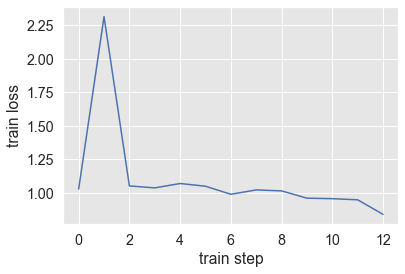

accuracy: 0.5714285714285714


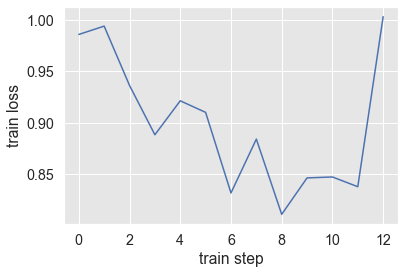

accuracy: 0.5889724310776943


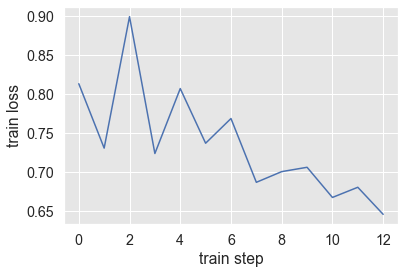

accuracy: 0.7393483709273183


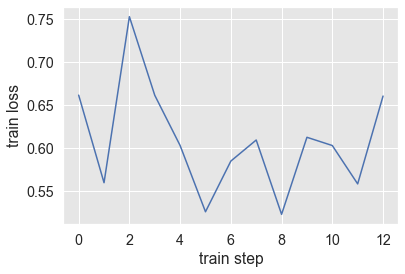

accuracy: 0.7844611528822055


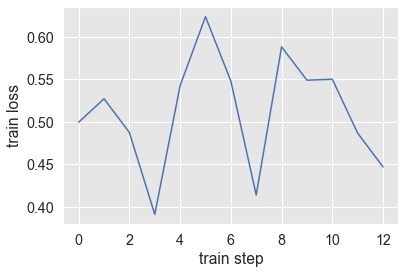

accuracy: 0.7869674185463659


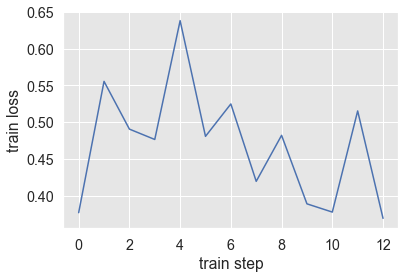

accuracy: 0.8245614035087719


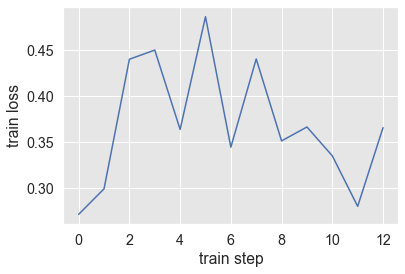

accuracy: 0.8320802005012531


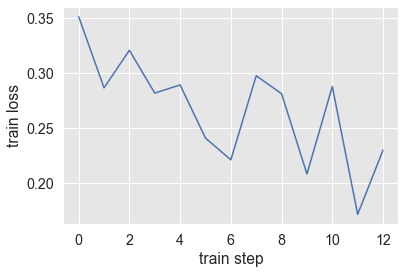

accuracy: 0.8546365914786967


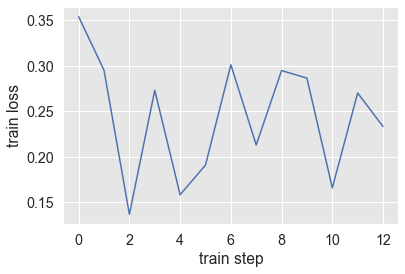

accuracy: 0.9172932330827067


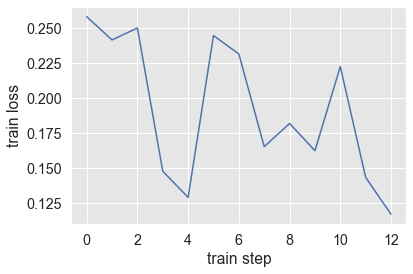

accuracy: 0.9072681704260651


In [17]:
for epoch in range(n_epochs):
    train_epoch(model, train_loader, criterion, optimizer, cuda)
    acc = run_test(model, test_loader, cuda)
    scheduler.step()
    print(f'accuracy: {acc}')

### Оценка эффективности модели

In [18]:
def evaluation(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        true_labels, pred_labels = [], []
        for imgs, t_true_labels in test_loader:
            pred_labels += np.argmax(model(imgs.to(cuda)).squeeze().cpu(), axis=1).tolist()
            true_labels += t_true_labels.tolist()
        acc = accuracy_score(true_labels, pred_labels)
        bacc = balanced_accuracy_score(pred_labels, true_labels)
        pr = precision_score(true_labels, pred_labels, average='weighted')
        recall = recall_score(true_labels, pred_labels, average='weighted')
        print(f'accuracy: {acc}')
        print(f'balanced accuracy: {bacc}')
        print(f'precision: {pr}')
        print(f'recall: {recall}')

        fpr, tpr, thresholds = roc_curve(true_labels, pred_labels, pos_label=1)
        auc_score = auc(fpr, tpr)
        print(f'auc: {auc_score}')
        conf_matrix = confusion_matrix(true_labels, pred_labels)
        heatmap = sns.heatmap(conf_matrix, annot=True, fmt='g')
        heatmap.set(xlabel='Predicted label', ylabel='True label')
        plt.show()

accuracy: 0.9072681704260651
balanced accuracy: 0.9030958030770696
precision: 0.9097745903591071
recall: 0.9072681704260651
auc: 0.4028662420382166


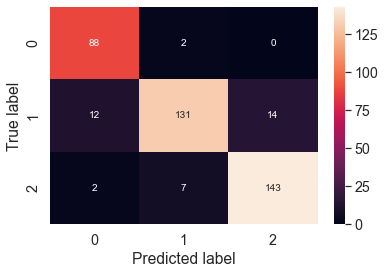

In [19]:
evaluation(model, test_loader, cuda)

### Сохранение весов модели

In [102]:
path = "C:/Users/Wxei/fitoBack/savedModels/basic-noSoftmax-pretrained-95.5.pt"

In [103]:
torch.save(model, path)